In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import os
import sys
import seaborn as sns
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img

In [2]:
# Definindo o caminho dos diretorios
base_dir = 'D:/michel/data/amazonia/kaggle'
train_dir = os.path.join(base_dir, 'train-jpg')
test_dir = os.path.join(base_dir, 'test-jpg')
train_fnames = os.listdir(train_dir)
test_fnames = os.listdir(test_dir)

In [3]:
mapping_csv = pd.read_csv(base_dir + '/train_classes.csv')

In [5]:
mapping_csv.head(10)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water
7,train_7,haze primary
8,train_8,agriculture clear cultivation primary
9,train_9,agriculture clear cultivation primary road


Para citarmos alguma imagem, precisamos fazer diretório+arquivo:
train_dir + '/' + train_fnames[i]

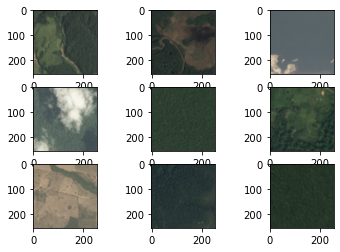

In [5]:
# Vamos plotar algumas imagens para ver se esta tudo ok.

for i in range(9):
    plt.subplot(330+1+i)
    filename = train_dir + '/' +train_fnames[i+1]
    image = imread(filename)
    plt.imshow(image)
plt.show()

# Criando mapas
Como vimos, as figuras não estão legendadas (no nome ou por pastas, por exemplo). Em vez disso, temos um arquivo csv separado com nomes das images e o respectivo label. Dessa forma, precisamos criar um mapa para atribuir os labels do .csv para as imagems!!

In [6]:
mapping_csv = pd.read_csv(base_dir + '/train_classes.csv')

In [7]:
mapping_csv.shape # Dimensões do dataframe com os labels

(40479, 2)

In [8]:
print(len(train_fnames)) # Quantida de training images

40479


Vamos criar um conjunto (set) de tags para cada atributo na coluna tags. Como uma figura pode ter mais de uma classificação, então iremos atribuir uma lista de classificações para cada imagem. Dessa forma, precisamos transformar as str da tag em numeros

In [9]:
labels = set()
for i in range (len(mapping_csv)):
    tags = mapping_csv['tags'][i].split(' ')
    labels.update(tags)

In [10]:
labels

{'agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water'}

In [11]:
labels = list(labels)
labels.sort()

In [12]:
labels

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [13]:
# Agora vamos criar um dicionário para mapear as tags em números

In [14]:
labels_map = {labels[i]:i for i in range(len(labels))}

In [15]:
labels_map

{'agriculture': 0,
 'artisinal_mine': 1,
 'bare_ground': 2,
 'blooming': 3,
 'blow_down': 4,
 'clear': 5,
 'cloudy': 6,
 'conventional_mine': 7,
 'cultivation': 8,
 'habitation': 9,
 'haze': 10,
 'partly_cloudy': 11,
 'primary': 12,
 'road': 13,
 'selective_logging': 14,
 'slash_burn': 15,
 'water': 16}

In [16]:
# Agora criamos o dicionário inverso,
# para podemos traduzir os resultados no final do modelo

In [17]:
inv_labels_map = {i:labels[i] for i in range(len(labels))}

In [18]:
inv_labels_map

{0: 'agriculture',
 1: 'artisinal_mine',
 2: 'bare_ground',
 3: 'blooming',
 4: 'blow_down',
 5: 'clear',
 6: 'cloudy',
 7: 'conventional_mine',
 8: 'cultivation',
 9: 'habitation',
 10: 'haze',
 11: 'partly_cloudy',
 12: 'primary',
 13: 'road',
 14: 'selective_logging',
 15: 'slash_burn',
 16: 'water'}

In [19]:
# Podemos fazer isso em apenas 1 função:

In [20]:
def create_tag_map(mapping_csv):
    labels= set()
    for i in range(len(mapping_csv)):
        tags = mapping_csv['tags'][i].split(' ')
        labels.update(tags)
    
    labels = list(labels)
    labels.sort()
    labels_map = {labels[k]:k for k in range(len(labels))}
    inv_labels_map = {k:labels[k] for k in range(len(labels))}
    return labels_map, inv_labels_map

In [21]:
labels_map, inv_labels_map = create_tag_map(mapping_csv)

In [22]:
print(len(labels_map)) # Quantidade de categorias

17


# Ainda nao criamos o map das imagens!

<AxesSubplot:xlabel='tags', ylabel='count'>

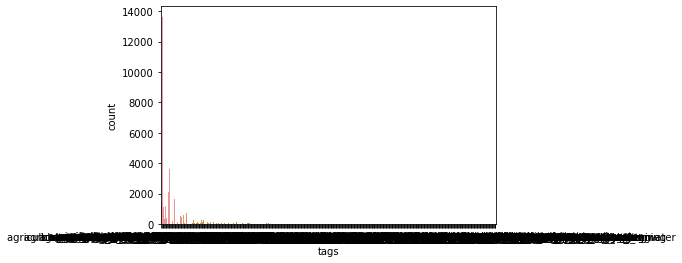

In [23]:
sns.countplot(data = mapping_csv, x='tags')

In [24]:
# Criando um mapeamento dos nomes dos arquivos para as tags
def create_file_mapping(mapping_csv):
    mapping=dict() # Criamos um dicionário vazio
    for j in range(len(mapping_csv)):
        """ percorremos o dataframe inteiro, pegando cada nome da imagem
        e sua respectiva tag, então separamos a tag por espaço
        e dizemos que o nome da tag é igual a sua tag, isso cria o dicionário!
        """
        name, tags = mapping_csv['image_name'][j], mapping_csv['tags'][j]
        mapping[name] = tags.split(' ')
    return mapping

In [25]:
mapping = create_file_mapping(mapping_csv)

In [26]:
mapping

{'train_0': ['haze', 'primary'],
 'train_1': ['agriculture', 'clear', 'primary', 'water'],
 'train_2': ['clear', 'primary'],
 'train_3': ['clear', 'primary'],
 'train_4': ['agriculture', 'clear', 'habitation', 'primary', 'road'],
 'train_5': ['haze', 'primary', 'water'],
 'train_6': ['agriculture', 'clear', 'cultivation', 'primary', 'water'],
 'train_7': ['haze', 'primary'],
 'train_8': ['agriculture', 'clear', 'cultivation', 'primary'],
 'train_9': ['agriculture', 'clear', 'cultivation', 'primary', 'road'],
 'train_10': ['agriculture', 'clear', 'primary', 'slash_burn', 'water'],
 'train_11': ['clear', 'primary', 'water'],
 'train_12': ['cloudy'],
 'train_13': ['clear', 'primary'],
 'train_14': ['cloudy'],
 'train_15': ['clear', 'primary'],
 'train_16': ['clear', 'primary'],
 'train_17': ['partly_cloudy', 'primary'],
 'train_18': ['clear', 'primary'],
 'train_19': ['agriculture', 'clear', 'primary', 'road'],
 'train_20': ['agriculture', 'clear', 'primary', 'water'],
 'train_21': ['clea

# Carregando as images!
Agora podemos enfim tentar carregar as imagens (Se a RAM conseguir).
Vamos diminuir o tamanho das imagens (para 128), para facilitar e transformar seus valores em 8 bits (0 a 255 o valor do pixel).


In [27]:
# carregando as imagens
filename = train_dir +'/'+ train_fnames[1]
pic = load_img(filename, target_size=(128,128))

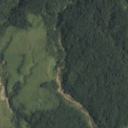

In [28]:
pic

In [29]:
# convertendo para array:
pic = img_to_array(pic, dtype='uint8')

In [30]:
pic.shape

(128, 128, 3)

In [31]:
# Criando one-hot-enconde:
def one_hot_enconde(tags, mapping):
    enconding = np.zeros(len(mapping), dtype='uint8')
    for tag in tags:
        enconding[mapping[tag]] = 1
    return enconding

In [32]:
# Criando uma função para carregar as imagens
def load_dataset(path, file_mapping, tag_mapping):
    pics, targets = list(), list()
    for filename in os.listdir(train_dir):
        pic = load_img(path+'/'+filename, target_size=(128,128))
        pic = img_to_array(pic, dtype='uint8')
        tags = file_mapping[filename[:-4]]
        target = one_hot_enconde(tags, tag_mapping)
        pics.append(pic)
        targets.append(target)
        
    X = np.asarray(pics, dtype='uint8')
    y = np.asarray(targets, dtype='uint8')
    return X, y

Vamos Atacar!

In [33]:
filename='train_classes.csv'
mapping_csv = pd.read_csv(base_dir + '/' +filename)

In [34]:
tag_mapping, _ = create_tag_map(mapping_csv)

In [35]:
file_mapping = create_file_mapping(mapping_csv)

In [36]:
X, y = load_dataset(train_dir, file_mapping, tag_mapping)
print(X.shape, y.shape)

(40479, 128, 128, 3) (40479, 17)


In [39]:
np.savez_compressed('amazon_data.npz', X, y)

In [40]:
# Para carregar os dados
# data = np.load('amazon_data.npz')
# X, y = data['arr_0'], data['arr_1']

# Criando o modelo